### Financial Machine Learning

지금까지 배운 내용을 토대로 금융 머신러닝 프로젝트에서 전략 수립과 연구가 어떻게 이뤄지는지 간단한 파이프라인을 그려 보도록 한다

#### 1. Data Import

가격 정보를 불러온다

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf

start_date = '1962-01-01'
end_date = '2024-01-18'
ticker = 'XOM'

data = yf.download(ticker, start_date, end_date)
data.drop('Adj Close', axis = 1, inplace = True)
data

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Volume
Date,,,,,
1962-01-02,0.000000,1.589844,1.578125,1.578125,902400
1962-01-03,0.000000,1.601563,1.578125,1.601563,1200000
1962-01-04,0.000000,1.613281,1.597656,1.605469,1088000
1962-01-05,0.000000,1.613281,1.566406,1.570313,1222400
1962-01-08,0.000000,1.582031,1.546875,1.566406,1388800
...,...,...,...,...,...
2024-01-10,99.800003,99.800003,98.160004,98.690002,18206100
2024-01-11,99.040001,99.500000,98.559998,98.669998,15833400
2024-01-12,100.139999,100.650002,99.169998,99.949997,18032100


In [2]:
data_ret = np.log(data.Close / data.Close.shift(1)).dropna()
data_ret.head()

Date
1962-01-03    0.014743
1962-01-04    0.002436
1962-01-05   -0.022141
1962-01-08   -0.002491
1962-01-09   -0.002497
Name: Close, dtype: float64

#### 2. Fractionally Differentiated Features

Fractionally Differentiated Feature를 생성하여 추가한다

 - 시계열의 정상성 : mean, variance, covariance가 시간이 지나도 변하지 않는 성질
 - 시계열 분석에서는 정상성을 가진 자료를 사용해야 한다 → 주로 사용하는 데이터 형태 '주가 수익률' (1차 차분)
 - But 이 경우 데이터가 가진 메모리를 잃어버린다는 단점이 있음 (수익률과 주가 데이터간 상관계수는 0)
 - 그래서 생기는 딜레마 : Stationary vs Memory
 
 - 해결책? 분수 차분!!

In [3]:
from FinancialMachineLearning.features.fracdiff import FractionalDifferentiatedFeatures
import statsmodels.api as sm

In [4]:
print(data.columns)

Index(['Open', 'High', 'Low', 'Close', 'Volume'], dtype='object')


- 0~1까지 21번(0.05차원씩) 차분을 하면서 ADF test 검정값 확인
- P value가 0.05 이하여야 귀무가설(정상성이 아니라는) 기각 가능

In [5]:
def calculate_difference(df : pd.DataFrame, end = 1, numbers = 11) :
    cols = ['adfStat','pVal','lags','nObs','95% conf', 'corr']
    out = pd.DataFrame(columns = cols)
    for d in np.linspace(0, end, numbers):
        try:
            df1 = np.log(df).dropna()
            df2 = FractionalDifferentiatedFeatures.fracDiff(df1, d, thres = 1e-5)
            corr = np.corrcoef(df1.loc[df2.index, 'Close'], df2['Close'])[0,1]
            df2 = sm.tsa.stattools.adfuller(df2['Close'], maxlag = 1, regression = 'c', autolag = None)
            out.loc[d] = list(df2[:4]) + [df2[4]['5%']] + [corr]
        except Exception as e:
            print(f'd: {d}, error: {e}')
            continue
    return out

data_d = calculate_difference(data[['Close']], numbers = 21)

d: 0.05, error: maxlag must be less than (nobs/2 - 1 - ntrend) where n trend is the number of included deterministic regressors
d: 0.1, error: maxlag must be less than (nobs/2 - 1 - ntrend) where n trend is the number of included deterministic regressors


,adfStat,pVal,lags,nObs,95% conf,corr
0.00,-1.239567,6.563476e-01,1.0,12610.0,-2.861769,1.000000
0.15,-0.442746,9.027133e-01,1.0,4.0,-4.474365,0.991476
0.20,-2.247938,1.893088e-01,1.0,7.0,-3.477583,0.968651
0.25,-1.835089,3.631851e-01,1.0,10.0,-3.232950,0.950540
0.30,-4.221110,6.067346e-04,1.0,16.0,-3.068498,0.846214
0.35,-1.993643,2.893673e-01,1.0,24.0,-2.992216,0.884652
0.40,-4.332218,3.904804e-04,1.0,38.0,-2.941262,0.838695
0.45,-3.631743,5.182383e-03,1.0,60.0,-2.911073,0.829309
0.50,-4.303673,4.377518e-04,1.0,97.0,-2.891831,0.688683
0.55,-5.454059,2.605471e-06,1.0,158.0,-2.880013,0.397140


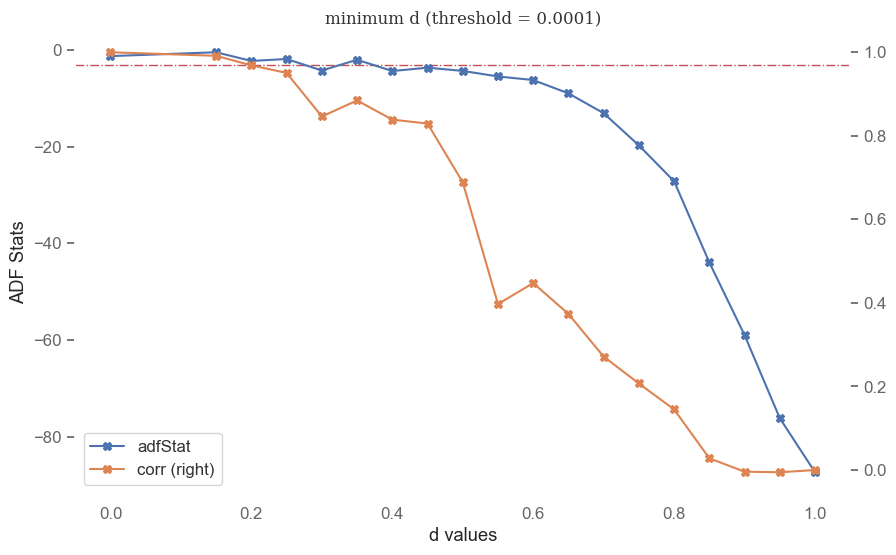

In [39]:
import matplotlib.pyplot as plt

f,ax = plt.subplots()
ax.axhline(data_d['95% conf'].mean(), lw = 1, color = 'r', ls = '-.')
data_d[['adfStat', 'corr']].plot(ax = ax, marker = 'X', secondary_y = 'corr')
ax.set_title('minimum d (threshold = 0.0001)', fontsize = 12, fontfamily = 'Serif')
ax.set_xlabel('d values')
ax.set_ylabel('ADF Stats')
ax.grid(False)
display(data_d)

0.30차분이 적절해 보이므로 0.30차분을 수행한다

In [5]:
frac = FractionalDifferentiatedFeatures.fracDiff_FFD(data[['Close']], 0.30)
data['fracdiff'] = frac

#### 3. Technical Features

ta library를 활용하여 다음과 같이 feature를 만들어 주도록 한다

In [6]:
from ta.volatility import BollingerBands
from ta.volume import money_flow_index, on_balance_volume
from ta.momentum import rsi
from ta.volume import volume_weighted_average_price
from ta.momentum import tsi
from ta.volume import ease_of_movement
from ta.volume import volume_price_trend

data['return'] = data_ret

indicator_bb = BollingerBands(close = data["Close"], window = 20, window_dev = 1) #20일 데이터로 볼린저밴드 생성

data['bb_bbm'] = indicator_bb.bollinger_mavg()
data['bb_bbh'] = indicator_bb.bollinger_hband()
data['bb_bbl'] = indicator_bb.bollinger_lband()

data['mfi'] = money_flow_index(
    high = data.High, low = data.Low, 
    close = data.Close, volume = data.Volume, window = 20
)
#MFI : 주가, 거래량으로 Money Flow Index 생성 - 대충 RSI에 거래량 붙인 것 (20이면 과매도, 80이면 과매수)
data['obv'] = on_balance_volume(close = data.Close, volume = data.Volume)
#OBV : 거래량 지표, OBV가 가격을 선행한다고 생각 (계산 : 오늘 종가 > 어제 종가 -> OBV에 오늘 거래량 더함. 반대면 뺌)
data['rsi'] = rsi(close = data.Close, window = 21)
data['rsi_signal'] = data['rsi'].rolling(window = 9).mean()
data['vwap'] = volume_weighted_average_price(
    high = data['High'], low = data['Low'],
    close = data['Close'], volume = data['Volume'], window = 20)
#VWAP : 일정기간동안 거래된 자산의 평균가격 (Σ거래가격*거래량/거래량)
data['tsi'] = tsi(close = data['Close'], window_fast = 13, window_slow = 15)
#TSI : 진정한 강도지수, RSI의 변형판
data['eom'] = ease_of_movement(
    high = data['High'], low = data.Low, volume = data.Volume, window = 20
)
#EOM : 거래량과 주가의 상관관계 (+은 상승, -은 하락, 절대값 크기는 거래량의 크기)
data['vpt'] = volume_price_trend(
    close = data.Close,
    volume = data.Volume
)
#VPT : 거래량 지표, OBV에서 단순 거래량에 종가의 변화율까지 곱한 값을 더함

#### 4. MicroStructural Features

시장미시구조적 특성을 추가하자

In [7]:
from FinancialMachineLearning.features.microstructure import *
spread = CorwinSchultz(high = data.High, low = data.Low)
cs_estimator = spread.corwin_schultz_estimator(window = 20)
data['corwin_schultz'] = cs_estimator
#H-L 스프레드(Corwin과 Schultz가 제안) : 유동성 측정 지표 (일별고가와 일별저가로 호가스프레드와 변동성을 추정)

In [8]:
bp_vol = spread.becker_parkinson_vol(window = 20)
data['becker_parkinson'] = bp_vol

#### 5. Primary Modeling

13주차에서 배운 개념을 활용하자

Primary Model에서는 방향만을 추정한다. 여기서는 Bollinger Band전략을 사용하여 가격이 상승할 것인지, 하락할 것인지 labeling을 하자

In [9]:
data['label'] = 0
data.loc[(data['rsi'] > 60) & (data['rsi'] > data['rsi_signal']), 'label'] = 1
data.loc[(data['rsi'] < 40) & (data['rsi_signal'] > data['rsi']), 'label'] = -1
print(data)

                  Open        High        Low      Close    Volume  fracdiff  \
Date                                                                           
1962-01-02    0.000000    1.589844   1.578125   1.578125    902400       NaN   
1962-01-03    0.000000    1.601563   1.578125   1.601563   1200000       NaN   
1962-01-04    0.000000    1.613281   1.597656   1.605469   1088000       NaN   
1962-01-05    0.000000    1.613281   1.566406   1.570313   1222400       NaN   
1962-01-08    0.000000    1.582031   1.546875   1.566406   1388800       NaN   
...                ...         ...        ...        ...       ...       ...   
2024-01-10   99.800003   99.800003  98.160004  98.690002  18206100  6.209395   
2024-01-11   99.040001   99.500000  98.559998  98.669998  15833400  6.697956   
2024-01-12  100.139999  100.650002  99.169998  99.949997  18032100  8.216582   
2024-01-16   99.820000  100.010002  97.529999  97.690002  20235700  5.724192   
2024-01-17   96.599998   97.959999  96.5

#### 6. Meta Labeling

Secondary Model은 Primary Model에서 나온 방향을 이용해 거래의 실행 여부만을 평가한다. 3개의 레이블[-1, 0, 1]을 이진 분류 모형[0, 1]으로 다시 labeling을 진행한다. 이 과정을 Meta Labeling이라고 한다

In [10]:
data['meta_label'] = 0
data.loc[(data['label'] == 1) | (data['label'] == -1), 'meta_label'] = 1
data.head()

,Open,High,Low,Close,Volume,fracdiff,return,bb_bbm,bb_bbh,bb_bbl,...,rsi,rsi_signal,vwap,tsi,eom,vpt,corwin_schultz,becker_parkinson,label,meta_label
Date,,,,,,,,,,,,,,,,,,,,,
1962-01-02,0.0,1.589844,1.578125,1.578125,902400,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
1962-01-03,0.0,1.601563,1.578125,1.601563,1200000,NaN,0.014743,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.011445,17822.144763,NaN,NaN,0,0
1962-01-04,0.0,1.613281,1.597656,1.605469,1088000,NaN,0.002436,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.022439,20475.640543,NaN,NaN,0,0
1962-01-05,0.0,1.613281,1.566406,1.570313,1222400,NaN,-0.022141,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,-0.059917,-6292.057162,NaN,NaN,0,0
1962-01-08,0.0,1.582031,1.546875,1.566406,1388800,NaN,-0.002491,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,-0.064273,-9747.415060,NaN,NaN,0,0


#### 7. Secondary Modeling

Meta Label을 target으로 지정하고, 2번에서 지정한 technical feature들을 이용하여 이진 분류 모형을 수행해 보자. 여기서, RSI 관련 feature들은 labeling에 사용되었으므로 고려하지 않는다.
볼린저 밴드 또한 가격과 관련이 있으므로 제거한다.

모형의 검증을 위해 test data는 0.2로 지정하고 shuffle = False로 지정한다

In [11]:
matrix = data.drop(['Open','High','Low','Close','rsi','rsi_signal', 'bb_bbm', 'bb_bbh', 'bb_bbl'], axis = 1)
matrix.dropna(inplace = True)
matrix.head()

,Volume,fracdiff,return,mfi,obv,vwap,tsi,eom,vpt,corwin_schultz,becker_parkinson,label,meta_label
Date,,,,,,,,,,,,,
1971-02-19,1600000,0.241577,-0.005021,58.080902,299484800,2.237561,34.981300,-0.007629,2.370633e+06,0.023642,0.000000,1,1
1971-02-22,1766400,0.232399,-0.003361,53.933629,297718400,2.242890,35.272002,-0.010366,2.364706e+06,0.014665,0.000000,1,1
1971-02-23,1840000,0.240150,0.003361,59.146190,299558400,2.249730,35.979121,0.006219,2.370900e+06,0.018439,0.000000,1,1
1971-02-24,2297600,0.236425,0.000000,65.610282,301856000,2.258501,36.539350,0.001328,2.370900e+06,0.022370,0.000000,1,1
1971-02-25,2460800,0.277100,0.018288,69.962874,304316800,2.267122,39.666134,0.068520,2.416318e+06,0.000000,0.023382,1,1


In [13]:
from sklearn.model_selection import train_test_split

X = matrix.drop(['meta_label','label'], axis = 1)
y = matrix['meta_label']

X_train = X.loc[:'2019']
X_test = X.loc['2020':]
y_train = y.loc[:'2019']
y_test = y.loc['2020':]

Random Forest를 사용한다

In [14]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(
    criterion = 'entropy',
    class_weight = 'balanced_subsample',
    min_weight_fraction_leaf = 0.0,
    random_state = 42,
    n_estimators = 1000,
    max_features = 6,
    oob_score = True,
    n_jobs = 1
)
#class_weight : 3가지 옵션이 있음. 아예 생략 / balanced(샘플의 수에 따라 가중치 부여)
#               balanced_subsample : weight가 부트스트랩(잘못 분류된 애들을 재학습) 때마다 balanced방식으로 가중치 새로 부여
#oob_score : 부트스트랩을 하면서 트리마다 빠지는 데이터에 대해 그걸 테스트 데이터로 사용하며 평가 계산을 할 것이냐?
fit = forest.fit(X = X_train, y = y_train)
oob_score = fit.oob_score_

#### 8. Feature Importances

각 변수의 설명력을 확인해 본다

In [15]:
cont = pd.Series(X_train.index, index = X_train.index, name = 't1') # 포지션 보유 한도 임의 지정

In [16]:
print(cont)

Date
1971-02-19   1971-02-19
1971-02-22   1971-02-22
1971-02-23   1971-02-23
1971-02-24   1971-02-24
1971-02-25   1971-02-25
                ...    
2019-12-24   2019-12-24
2019-12-26   2019-12-26
2019-12-27   2019-12-27
2019-12-30   2019-12-30
2019-12-31   2019-12-31
Name: t1, Length: 12326, dtype: datetime64[ns]


In [17]:
from FinancialMachineLearning.feature_importance.importance import *
from FinancialMachineLearning.cross_validation.cross_validation import PurgedKFold, ml_cross_val_score
from sklearn.metrics import accuracy_score

cv_gen = PurgedKFold(n_splits = 5, samples_info_sets = cont) #split : split 갯수, sample_info_sets : 정보 추출이 이뤄진 기간
oos_score = ml_cross_val_score(forest, X_train, y_train, cv_gen = cv_gen, scoring = accuracy_score).mean()
#ml_cross_val_score(classifier, X, y, BaseCrossValidator, 평가방식)
mdi = mean_decrease_impurity(fit, X_train.columns) #MDI : 불순물의 감소정도를 Feature Importance 정도로 판단한다

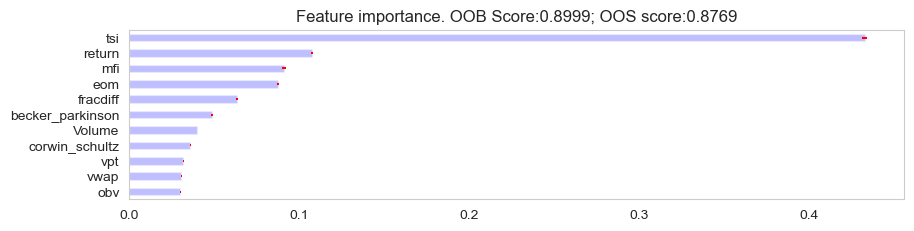

In [18]:
plot_feature_importance(
    mdi,
    oob_score = oob_score,
    oos_score = oos_score,
    save_fig = True,
    output_path = './data_feature_importance.png'
)
plt.grid(False)
plt.show()

In [20]:
from sklearn.metrics import log_loss

mda = mean_decrease_accuracy(fit, X_train, y_train, cv_gen, scoring = log_loss)

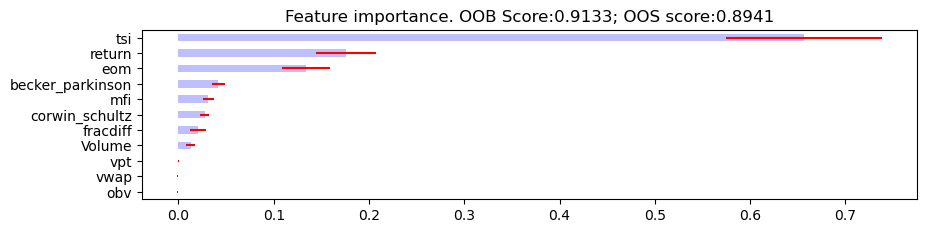

In [21]:
plot_feature_importance(
    mda,
    oob_score = oob_score,
    oos_score = oos_score,
    save_fig = True,
    output_path = './data_MDA_feature_importance.png'
)
plt.grid(False)
plt.show()

필요한 경우 SHAP Model로도 분석할 수 있지만, 여기서는 시간이 오래 걸리므로 추정하지 않는다

#### 9. 결과 출력

여러 성과 지표들을 통해 Machine Learning Model의 추정 결과를 확인한다

In [19]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc

y_prob = forest.predict_proba(X_test)[:, 1] #확률까지 출력
y_pred = forest.predict(X_test) #값만 출력
fpr, tpr, thresholds = roc_curve(y_test, y_prob) #False Positive 확률, True Positive확률
#thresholds : True Positive에 얼마나 비중을 둘 건지 파라미터값 (TP를 늘리면 FP도 늘어난다)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

Accuracy: 0.8672566371681416


In [20]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.92      0.91       788
           1       0.71      0.69      0.70       229

    accuracy                           0.87      1017
   macro avg       0.81      0.80      0.81      1017
weighted avg       0.87      0.87      0.87      1017


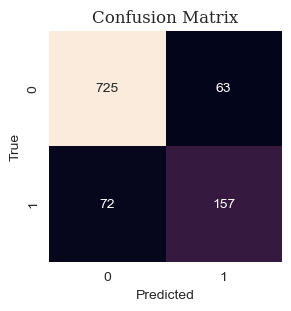

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (3, 3))
sns.heatmap(cm, annot = True, fmt = 'd', cbar = False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix', fontsize = 12, fontfamily = 'Serif')
plt.show()

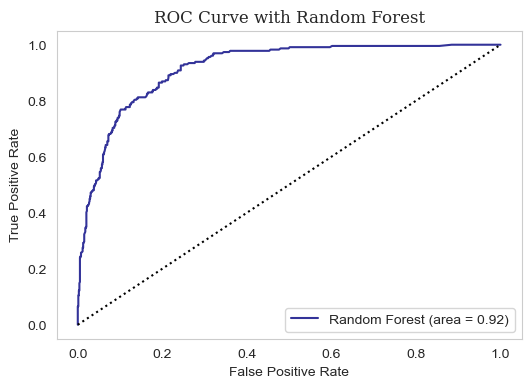

In [23]:
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize = (6, 4))
plt.plot(fpr, tpr, label = 'Random Forest (area = {:.2f})'.format(roc_auc), color = 'navy', alpha = 0.8)
plt.plot([0, 1], [0, 1], 'k:')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve with Random Forest', fontsize = 12, fontfamily = 'Serif')
plt.grid(False)
plt.legend()
plt.show()

<Axes: title={'center': 'Equity Progression'}>

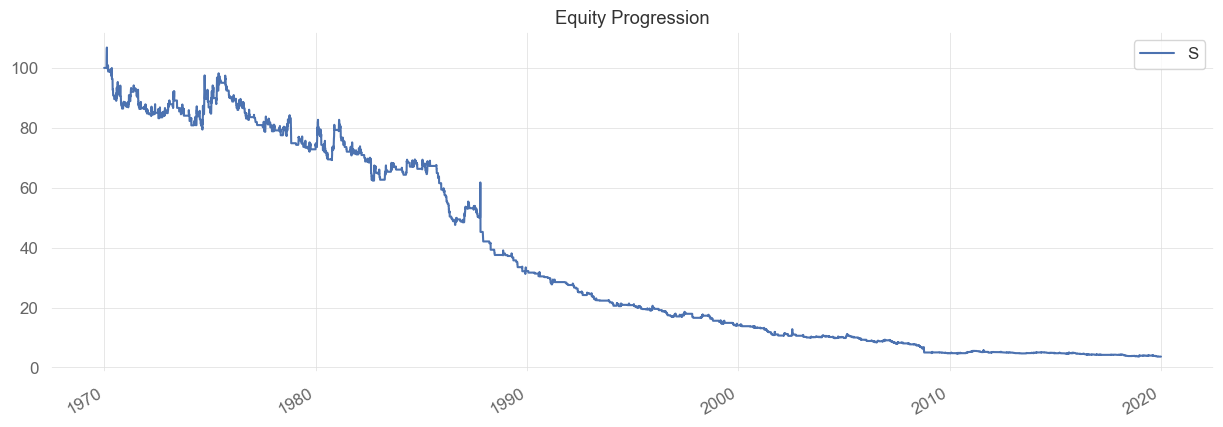

In [28]:
import bt
import ffn
import quantstats as qs

price = data['Close'].to_frame()
Label = data['label'].to_frame()
Label.columns = ['Close']

algos_raw = [
    bt.algos.RunDaily(),
    bt.algos.SelectAll(),
    bt.algos.WeighTarget(Label),
    bt.algos.Rebalance()
]

test = bt.Strategy(name = 'S',algos = algos_raw)
base = bt.Backtest(strategy = test, data = price)

res = bt.run(base)
res.plot()

#실환가...

#### 10. Betting Size

In [29]:
from FinancialMachineLearning.bet_sizing.bet_sizing import *

event_prob = pd.DataFrame()
event_prob['t1'] = pd.Series(X_test.index, index = X_test.index, name = 't1')
event_prob['prob'] = fit.predict_proba(X_test)[:,1]
event_prob.index = pd.Series(X_test.index, index = X_test.index, name = 't1')

In [30]:
event_prob['side'] = matrix['label']

In [31]:
event_prob

,t1,prob,side
t1,,,
2011-10-12,2011-10-12,0.192,0
2011-10-13,2011-10-13,0.064,0
2011-10-14,2011-10-14,0.332,0
2011-10-17,2011-10-17,0.118,0
2011-10-18,2011-10-18,0.535,0
...,...,...,...
2019-12-24,2019-12-24,0.014,0
2019-12-26,2019-12-26,0.009,0
2019-12-27,2019-12-27,0.006,0


In [32]:
event_prob['bet_size_prob'] = bet_size_probability(events = event_prob, prob = event_prob['prob'], num_classes = 3)
#bet_sizes = (prob - 1/num_classes) / (prob * (1 - prob))**0.5

In [33]:
event_prob

,t1,prob,side,bet_size_prob
t1,,,,
2011-10-12,2011-10-12,0.192,0,-0.280277
2011-10-13,2011-10-13,0.064,0,-0.728855
2011-10-14,2011-10-14,0.332,0,-0.002259
2011-10-17,2011-10-17,0.118,0,-0.495532
2011-10-18,2011-10-18,0.535,0,0.314026
...,...,...,...,...
2019-12-24,2019-12-24,0.014,0,-0.993431
2019-12-26,2019-12-26,0.009,0,-0.999406
2019-12-27,2019-12-27,0.006,0,-0.999978


In [34]:
from multiprocessing import cpu_count

avg_active_bet_sizes = avg_active_signals(event_prob.rename(columns ={'bet_size_prob': 'signal'}), num_threads = cpu_count())
event_prob['avg_active_bet_size'] = avg_active_bet_sizes

2024-01-18 23:26:25.612114 100.0% mp_avg_active_signals done after 0.11 minutes. Remaining 0.0 minutes.


In [35]:
display(event_prob)

,t1,prob,side,bet_size_prob,avg_active_bet_size
t1,,,,,
2011-10-12,2011-10-12,0.192,0,-0.280277,0
2011-10-13,2011-10-13,0.064,0,-0.728855,0
2011-10-14,2011-10-14,0.332,0,-0.002259,0
2011-10-17,2011-10-17,0.118,0,-0.495532,0
2011-10-18,2011-10-18,0.535,0,0.314026,0
...,...,...,...,...,...
2019-12-24,2019-12-24,0.014,0,-0.993431,0
2019-12-26,2019-12-26,0.009,0,-0.999406,0
2019-12-27,2019-12-27,0.006,0,-0.999978,0


In [36]:
print("Summary statistics on the bet size columns:")
display(event_prob[['prob', 'bet_size_prob', 'avg_active_bet_size']].describe())

Summary statistics on the bet size columns:


,prob,bet_size_prob,avg_active_bet_size
count,2068.000000,2068.000000,2068.0
mean,0.217934,-0.360045,0.0
std,0.211148,0.485941,0.0
min,0.000000,-1.000000,0.0
25%,0.066000,-0.718400,0.0
50%,0.126000,-0.467886,0.0
75%,0.348000,0.024563,0.0
max,0.924000,0.974183,0.0


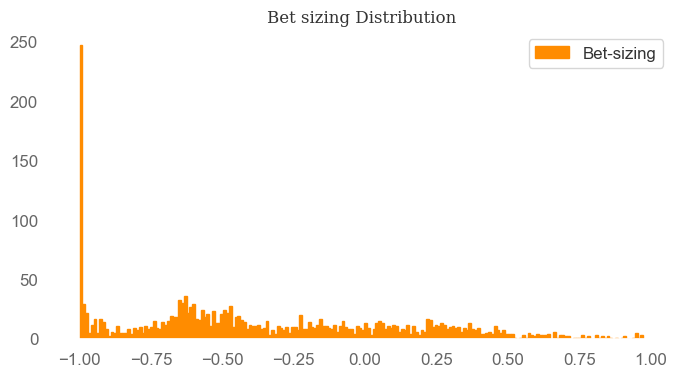

In [37]:
plt.figure(figsize = (8, 4))
plt.hist(
    event_prob.bet_size_prob, 
    bins = 200, 
    color = 'darkorange', 
    edgecolor = 'darkorange', 
    label = 'Bet-sizing'
)
plt.legend()
plt.grid(False)
plt.title('Bet sizing Distribution', fontsize = 12, fontfamily = 'Serif')
plt.show()

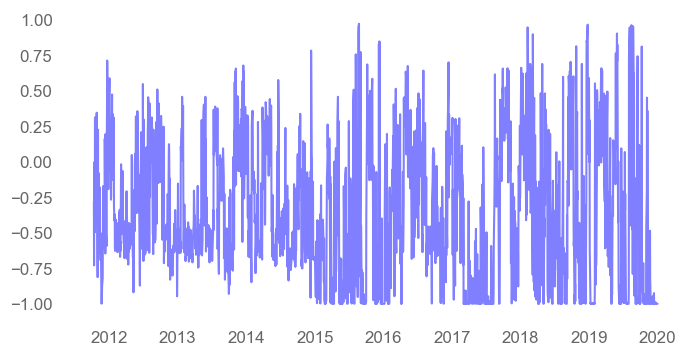

In [38]:
plt.figure(figsize = (8, 4))
plt.plot(event_prob.bet_size_prob, color = 'blue', alpha = 0.5)
plt.grid(False)